In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
train_df = pd.read_csv('../dump/train_modified.csv')
test_df = pd.read_csv('../dump/test_modified.csv')

In [4]:
target='acc_now_delinq'
IDcol = 'member_id'
train_df[target].value_counts()

0.0    697707
1.0      3258
Name: acc_now_delinq, dtype: int64

In [ ]:
train_df.head().transpose()

In [5]:
def f2_score(preds, dtrain):  # preds是结果（概率值），dtrain是个带label的DMatrix
    beta = 2
    label = dtrain.get_label()  # 提取label

    # preds = 1.0 / (1.0 + np.exp(-preds))
    pred = [int(i >= 0.5) for i in preds]

    precision = metrics.precision_score(label,pred)
    recall = metrics.recall_score(label,pred)

    return 'f2_score', ((np.square(beta)+1)*precision * recall / (np.square(beta)*precision + recall))

In [6]:
# test_results = pd.read_csv('test_results.csv')
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
#         watchlist = [(xgtrain,'train',(xgtest,'test'))]
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, 
                          feval = f2_score, maximize=True,
                          early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['acc_now_delinq'],eval_metric=f2_score)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(train_df['acc_now_delinq'].values, dtrain_predictions))
    print("Recall : %.4g" % metrics.recall_score(train_df['acc_now_delinq'].values, dtrain_predictions))
    print("Fbeta Score : %.4g" % metrics.fbeta_score(train_df['acc_now_delinq'].values, dtrain_predictions,beta=2))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(train_df['acc_now_delinq'], dtrain_predprob))
    print(metrics.classification_report(train_df['acc_now_delinq'], dtrain_predictions))

    #     Predict on testing data:
    test_df['predprob'] = xgb1.predict_proba(test_df[predictors])[:,1]
    #     results = test_results.merge(dtest[['ID','predprob']], on='ID')
    #     print('AUC Score (Test): %f' % metrics.roc_auc_score(results['Disbursed'], results['predprob']))

    feat_imp = pd.Series(xgb1.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    

In [7]:
predictors = [x for x in train_df.columns if x not in [target,IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        n_jobs = -1,
        scale_pos_weight=100,
        seed=27)
modelfit(xgb1, train_df, test_df, predictors)
print("Training Finsh")

[0]	train-error:0.140377+0.0266451	train-f2_score:0.067441+0.00331621	test-error:0.140523+0.0276279	test-f2_score:0.0636092+0.00328488
[1]	train-error:0.107577+0.0118728	train-f2_score:0.0765726+0.00215421	test-error:0.107853+0.0116568	test-f2_score:0.0686238+0.00386859
[2]	train-error:0.102667+0.00559745	train-f2_score:0.079564+0.000573289	test-error:0.102979+0.00555463	test-f2_score:0.0719572+0.00234524
[3]	train-error:0.0987268+0.00826942	train-f2_score:0.0842208+0.00258381	test-error:0.098751+0.00801506	test-f2_score:0.0748836+0.00303383
[4]	train-error:0.0950352+0.00813431	train-f2_score:0.0864376+0.00336525	test-error:0.0951274+0.00749174	test-f2_score:0.0767822+0.00343099
[5]	train-error:0.0938724+0.0111961	train-f2_score:0.0889848+0.00411063	test-error:0.0940702+0.0105727	test-f2_score:0.0789052+0.00482071
[6]	train-error:0.092952+0.00831193	train-f2_score:0.0900388+0.00395172	test-error:0.0930702+0.00745886	test-f2_score:0.0802118+0.00520058
[7]	train-error:0.0924692+0.0066849

[59]	train-error:0.0979004+0.00177622	train-f2_score:0.122459+0.00124716	test-error:0.0987896+0.00230852	test-f2_score:0.0958106+0.0037991
[60]	train-error:0.0979738+0.0017811	train-f2_score:0.1227+0.00123002	test-error:0.0988026+0.00235588	test-f2_score:0.0960894+0.00385742
[61]	train-error:0.0978822+0.00146087	train-f2_score:0.123349+0.00101571	test-error:0.0987754+0.00210422	test-f2_score:0.0958148+0.00399282
[62]	train-error:0.0978248+0.00131839	train-f2_score:0.123609+0.000748152	test-error:0.0987326+0.00203192	test-f2_score:0.0961466+0.00396709
[63]	train-error:0.098026+0.00137843	train-f2_score:0.123584+0.000525308	test-error:0.0989336+0.00214255	test-f2_score:0.0959922+0.00404354
[64]	train-error:0.097993+0.00130478	train-f2_score:0.124163+0.000470366	test-error:0.0989836+0.00201188	test-f2_score:0.0961228+0.00400164
[65]	train-error:0.0980386+0.00122904	train-f2_score:0.124459+0.000389739	test-error:0.0990248+0.00186062	test-f2_score:0.0957294+0.00334129
[66]	train-error:0.098

[118]	train-error:0.0937028+0.00109526	train-f2_score:0.143094+0.000788826	test-error:0.0951946+0.00159666	test-f2_score:0.0986036+0.00515668
[119]	train-error:0.0934882+0.00121517	train-f2_score:0.143662+0.00107471	test-error:0.0949304+0.00157292	test-f2_score:0.0985912+0.00507303
[120]	train-error:0.0933232+0.00117312	train-f2_score:0.144296+0.000757532	test-error:0.0947906+0.00157643	test-f2_score:0.098471+0.00506207
[121]	train-error:0.0933074+0.00112413	train-f2_score:0.14442+0.000795935	test-error:0.0947978+0.00153136	test-f2_score:0.0987684+0.00482782
[122]	train-error:0.0931998+0.000979832	train-f2_score:0.144896+0.000926209	test-error:0.0947308+0.00147306	test-f2_score:0.0987668+0.0049568
[123]	train-error:0.0930142+0.00108931	train-f2_score:0.145387+0.00113047	test-error:0.094568+0.00156621	test-f2_score:0.0990336+0.0050689
[124]	train-error:0.0928928+0.00113084	train-f2_score:0.145884+0.00107453	test-error:0.0944196+0.00162008	test-f2_score:0.099103+0.00490317
[125]	train-er

[177]	train-error:0.0860084+0.000905786	train-f2_score:0.165517+0.000550029	test-error:0.0882754+0.000967755	test-f2_score:0.100235+0.00546096
[178]	train-error:0.0858338+0.000969567	train-f2_score:0.165976+0.000519669	test-error:0.08814+0.00110962	test-f2_score:0.100368+0.00541866
[179]	train-error:0.0857972+0.000864297	train-f2_score:0.166156+0.000320284	test-error:0.0881558+0.00104396	test-f2_score:0.100028+0.00538358
[180]	train-error:0.0857018+0.000900325	train-f2_score:0.166493+0.00040105	test-error:0.088027+0.00116648	test-f2_score:0.100155+0.00524209
[181]	train-error:0.0854998+0.000888713	train-f2_score:0.166919+0.000388341	test-error:0.0878316+0.00112687	test-f2_score:0.100143+0.00491748
[182]	train-error:0.0853474+0.000935839	train-f2_score:0.167189+0.000555443	test-error:0.087729+0.0011809	test-f2_score:0.099985+0.00506847
[183]	train-error:0.085287+0.000926171	train-f2_score:0.167441+0.000530248	test-error:0.0876562+0.00105458	test-f2_score:0.100045+0.00493143
[184]	train-

[236]	train-error:0.07842+0.00125501	train-f2_score:0.188046+0.00142147	test-error:0.0811954+0.00140669	test-f2_score:0.101809+0.00601958
[237]	train-error:0.078317+0.00124473	train-f2_score:0.188441+0.00160724	test-error:0.0810638+0.00136636	test-f2_score:0.102144+0.00580538
[238]	train-error:0.0781548+0.00130162	train-f2_score:0.188802+0.00175777	test-error:0.0808756+0.00141115	test-f2_score:0.102063+0.00582774
[239]	train-error:0.0780216+0.00131031	train-f2_score:0.189006+0.00184392	test-error:0.0807532+0.00142727	test-f2_score:0.102051+0.00559426
[240]	train-error:0.0777502+0.00139419	train-f2_score:0.189709+0.00194646	test-error:0.0804662+0.0015389	test-f2_score:0.10201+0.00586761
[241]	train-error:0.0776564+0.00140585	train-f2_score:0.189906+0.00201502	test-error:0.0803662+0.00149687	test-f2_score:0.102113+0.00614643
[242]	train-error:0.0774544+0.00146812	train-f2_score:0.190583+0.00228583	test-error:0.080154+0.001554	test-f2_score:0.101845+0.00574701
[243]	train-error:0.0774002+

[295]	train-error:0.0710024+0.00134906	train-f2_score:0.212624+0.00224621	test-error:0.074189+0.00116928	test-f2_score:0.102859+0.00552337
[296]	train-error:0.0708406+0.00138012	train-f2_score:0.213227+0.00239862	test-error:0.0739964+0.00122909	test-f2_score:0.103002+0.00562752
[297]	train-error:0.0706726+0.00132315	train-f2_score:0.213822+0.00229946	test-error:0.0738724+0.00119508	test-f2_score:0.103213+0.00554044
[298]	train-error:0.0705176+0.00127565	train-f2_score:0.214479+0.00233192	test-error:0.0737596+0.00119981	test-f2_score:0.103344+0.00592929
[299]	train-error:0.070379+0.00127781	train-f2_score:0.214927+0.00252575	test-error:0.0736446+0.00107965	test-f2_score:0.10324+0.00588762
[300]	train-error:0.0702842+0.00126615	train-f2_score:0.21511+0.00232657	test-error:0.0734858+0.00108908	test-f2_score:0.103121+0.00578945
[301]	train-error:0.0701002+0.00130249	train-f2_score:0.215702+0.0023274	test-error:0.0733076+0.00118144	test-f2_score:0.103254+0.00620038
[302]	train-error:0.06999

[354]	train-error:0.0642922+0.00132934	train-f2_score:0.237655+0.00314283	test-error:0.068032+0.00130559	test-f2_score:0.104273+0.00657494
[355]	train-error:0.064091+0.00143876	train-f2_score:0.238372+0.00368532	test-error:0.0678478+0.00129523	test-f2_score:0.104019+0.00701743
[356]	train-error:0.06409+0.00151804	train-f2_score:0.238643+0.00389403	test-error:0.0678248+0.00133829	test-f2_score:0.104446+0.00712089
[357]	train-error:0.0639642+0.00147264	train-f2_score:0.239209+0.00365693	test-error:0.0676496+0.00128048	test-f2_score:0.10474+0.0071102
[358]	train-error:0.0638518+0.00143343	train-f2_score:0.239558+0.00362015	test-error:0.0674854+0.00128676	test-f2_score:0.10479+0.00718529
[359]	train-error:0.06379+0.00150413	train-f2_score:0.239978+0.00368133	test-error:0.0674958+0.0013647	test-f2_score:0.104459+0.00696495
[360]	train-error:0.063708+0.00144634	train-f2_score:0.240222+0.00367746	test-error:0.0674028+0.00131845	test-f2_score:0.104734+0.00677525
[361]	train-error:0.0635742+0.0

[413]	train-error:0.0581638+0.00128711	train-f2_score:0.263574+0.00362165	test-error:0.0623912+0.00102333	test-f2_score:0.105721+0.00610146
[414]	train-error:0.0581516+0.0012853	train-f2_score:0.263633+0.00357275	test-error:0.062367+0.00102538	test-f2_score:0.105584+0.00626889
[415]	train-error:0.0581216+0.00128417	train-f2_score:0.263808+0.00350631	test-error:0.0623652+0.00103548	test-f2_score:0.105072+0.00579494
[416]	train-error:0.0579596+0.00131203	train-f2_score:0.264441+0.00351433	test-error:0.0622382+0.00103658	test-f2_score:0.105239+0.00589112
[417]	train-error:0.0578542+0.00132707	train-f2_score:0.264887+0.00341446	test-error:0.06213+0.00106246	test-f2_score:0.105211+0.00573378
[418]	train-error:0.057726+0.00128354	train-f2_score:0.265406+0.00331196	test-error:0.0620458+0.00100549	test-f2_score:0.105322+0.00560419
[419]	train-error:0.0576156+0.00130384	train-f2_score:0.266035+0.00350749	test-error:0.0619432+0.00109044	test-f2_score:0.105294+0.0056118
[420]	train-error:0.057452

[472]	train-error:0.0524074+0.000951731	train-f2_score:0.290308+0.00280301	test-error:0.0570128+0.000778755	test-f2_score:0.106748+0.00664024
[473]	train-error:0.0523548+0.00101905	train-f2_score:0.290562+0.00316382	test-error:0.0569358+0.000874786	test-f2_score:0.106404+0.00684836
[474]	train-error:0.0521836+0.00106805	train-f2_score:0.291233+0.00349327	test-error:0.0567646+0.000913058	test-f2_score:0.106564+0.00706613
[475]	train-error:0.0521222+0.00110621	train-f2_score:0.291623+0.00350137	test-error:0.056719+0.000874445	test-f2_score:0.106529+0.00709556
[476]	train-error:0.0519944+0.00111711	train-f2_score:0.29227+0.00350779	test-error:0.0565962+0.000897694	test-f2_score:0.106615+0.00690014
[477]	train-error:0.0519318+0.00111658	train-f2_score:0.29258+0.0036198	test-error:0.0565676+0.000913447	test-f2_score:0.106473+0.00650834
[478]	train-error:0.0518474+0.00107868	train-f2_score:0.29295+0.00341476	test-error:0.056538+0.000870203	test-f2_score:0.106326+0.00650087
[479]	train-error:

KeyboardInterrupt: 

In [10]:
#Predict training set:
dtrain_predictions = xgb1.predict(train_df[predictors])
dtrain_predprob = xgb1.predict_proba(train_df[predictors])[:,1]

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9954
Recall : 0.001228
Fbeta Score : 0.001534
AUC Score (Train): 0.913381
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    697707
        1.0       1.00      0.00      0.00      3258

avg / total       1.00      1.00      0.99    700965



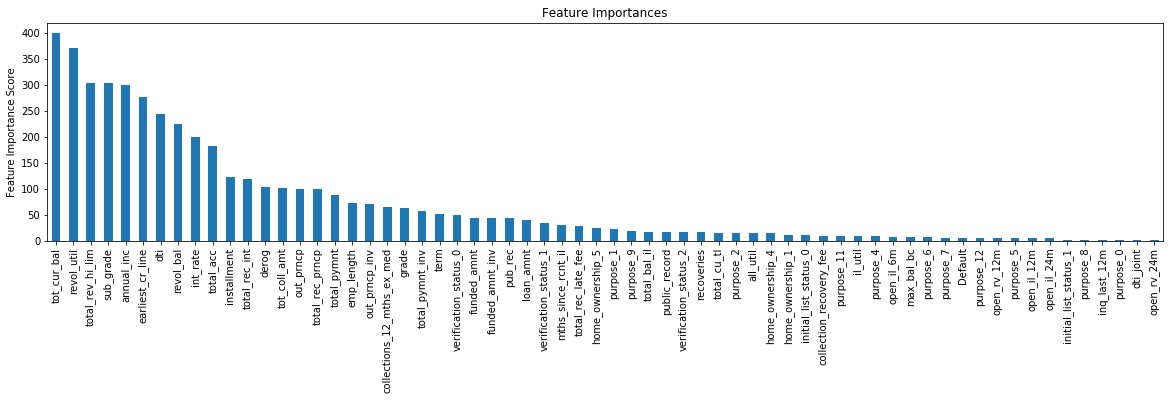

In [14]:
#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(train_df['acc_now_delinq'].values, dtrain_predictions))
print("Recall : %.4g" % metrics.recall_score(train_df['acc_now_delinq'].values, dtrain_predictions))
print("Fbeta Score : %.4g" % metrics.fbeta_score(train_df['acc_now_delinq'].values, dtrain_predictions,beta=2))
print("AUC Score (Train): %f" % metrics.roc_auc_score(train_df['acc_now_delinq'], dtrain_predprob))
print(metrics.classification_report(train_df['acc_now_delinq'], dtrain_predictions))

#     Predict on testing data:
test_df['predprob'] = xgb1.predict_proba(test_df[predictors])[:,1]
#     results = test_results.merge(dtest[['ID','predprob']], on='ID')
#     print('AUC Score (Test): %f' % metrics.roc_auc_score(results['Disbursed'], results['predprob']))

feat_imp = pd.Series(xgb1.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:

#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

In [ ]:
dtest_predictions=xgb1.predict(test_df[predictors])

In [ ]:
sub = pd.read_csv('../input/sample_submission.csv')
print(dtest_predictions.shape, sub.shape)
for c in sub.columns[sub.columns != IDcol]:
    sub[c] = dtest_predictions

In [ ]:
sub.loc[sub['acc_now_delinq'] == 1]

In [37]:
print('Writing csv ...')
sub.to_csv('../submission/xgb_starter.csv', index=False)  # Thanks to @inversion


Writing csv ...
